In [2]:
import matplotlib.pyplot as plt
from src.core.LangevinGillespie import LangevinGillespie
import time 

In [3]:
r = 19  # nm - distance from the rotational axis to the center of the sphere
a = 20  # nm - radius of a sphere (See https://en.wikipedia.org/wiki/Stokes_flow)
eta = 1e-9  # pN.s/nm^2

LG = LangevinGillespie()
LG.dt = 1e-6
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a, r, eta)
LG.method = "heun"

In [4]:
def computeSimulationTime():
    start = time.time()
    data = LG.simulate()
    end = time.time()
    return end - start

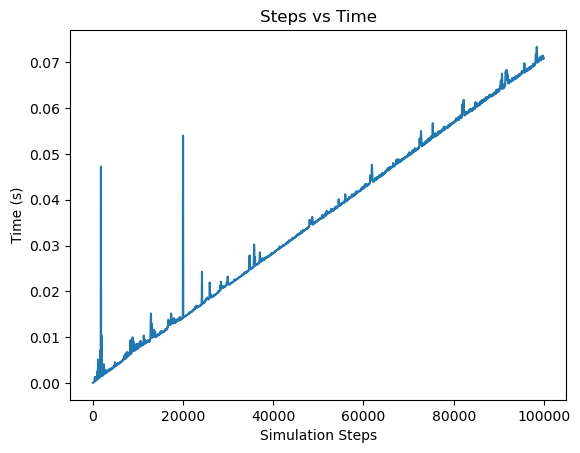

In [ ]:
MAX_SIMS = 100_000
angle = 0
LG.theta_0 = LG.initializeTheta(angle)
LG.theta_i = angle

# Run simulations for different step counts
times = []
for nSteps in range(1, MAX_SIMS, 50):
    LG.steps = nSteps
    elapsed_time = computeSimulationTime()
    times.append([elapsed_time, nSteps])

# Extract lists for plotting
sim_times = [t[0] for t in times]  # y-axis
n_steps = [t[1] for t in times]  # x-axis

# Plot
plt.plot(n_steps, sim_times, alpha=1, label=f"{angle}°")
plt.xlabel("Simulation Steps")
plt.ylabel("Time (s)")
plt.title("Steps vs Time")
plt.show()